In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

# Load BASELINE datasets
df_baseline_block_latency = pd.read_csv("baseline/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("baseline/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("baseline/write_bytes.csv")

# Load CPU STRESS datasets
df_cpustress_block_latency = pd.read_csv("cpu stress/block_count_latency_device.csv")
df_cpustress_read_bytes = pd.read_csv("cpu stress/read_bytes.csv")
df_cpustress_write_bytes = pd.read_csv("cpu stress/write_bytes.csv")

# Load IO datasets
df_IO_block_latency = pd.read_csv("IO pressure/block_count_latency_device.csv")
df_IO_read_bytes = pd.read_csv("IO pressure/read_bytes.csv")
df_IO_write_bytes = pd.read_csv("IO pressure/write_bytes.csv")

# Load MEM STRESS datasets
df_memstress_block_latency = pd.read_csv("mem stress/block_count_latency_device.csv")
df_memstress_read_bytes = pd.read_csv("mem stress/read_bytes.csv")
df_memstress_write_bytes = pd.read_csv("mem stress/write_bytes.csv")

# Load NET LOSS datasets
df_netloss_block_latency = pd.read_csv("net loss/block_count_latency_device.csv")
df_netloss_read_bytes = pd.read_csv("net loss/read_bytes.csv")
df_netloss_write_bytes = pd.read_csv("net loss/write_bytes.csv")


# Add source labels - BASELINE
df_baseline_block_latency["source"] = "BASELINE"
df_baseline_read_bytes["source"] = "BASELINE"
df_baseline_write_bytes["source"] = "BASELINE"

# Add source labels - CPU STRESS
df_cpustress_block_latency["source"] = "CPU_STRESS"
df_cpustress_read_bytes["source"] = "CPU_STRESS"
df_cpustress_write_bytes["source"] = "CPU_STRESS"

# Add source labels - DELAY
df_IO_block_latency["source"] = "DELAY"
df_IO_read_bytes["source"] = "DELAY"
df_IO_write_bytes["source"] = "DELAY"

# Add source labels - MEM STRESS
df_memstress_block_latency["source"] = "MEM_STRESS"
df_memstress_read_bytes["source"] = "MEM_STRESS"
df_memstress_write_bytes["source"] = "MEM_STRESS"

# Add source labels - NET LOSS
df_netloss_block_latency["source"] = "NET_LOSS"
df_netloss_read_bytes["source"] = "NET_LOSS"
df_netloss_write_bytes["source"] = "NET_LOSS"


# Convert to datetime - BASELINE
df_baseline_block_latency["Time"] = pd.to_datetime(df_baseline_block_latency["Time"])
df_baseline_read_bytes["Time"] = pd.to_datetime(df_baseline_read_bytes["Time"])
df_baseline_write_bytes["Time"] = pd.to_datetime(df_baseline_write_bytes["Time"])

# Convert to datetime - CPU STRESS
df_cpustress_block_latency["Time"] = pd.to_datetime(df_cpustress_block_latency["Time"])
df_cpustress_read_bytes["Time"] = pd.to_datetime(df_cpustress_read_bytes["Time"])
df_cpustress_write_bytes["Time"] = pd.to_datetime(df_cpustress_write_bytes["Time"])

# Convert to datetime - IO
df_IO_block_latency["Time"] = pd.to_datetime(df_IO_block_latency["Time"])
df_IO_read_bytes["Time"] = pd.to_datetime(df_IO_read_bytes["Time"])
df_IO_write_bytes["Time"] = pd.to_datetime(df_IO_write_bytes["Time"])

# Convert to datetime - MEM STRESS
df_memstress_block_latency["Time"] = pd.to_datetime(df_memstress_block_latency["Time"])
df_memstress_read_bytes["Time"] = pd.to_datetime(df_memstress_read_bytes["Time"])
df_memstress_write_bytes["Time"] = pd.to_datetime(df_memstress_write_bytes["Time"])

# Convert to datetime - NET LOSS
df_netloss_block_latency["Time"] = pd.to_datetime(df_netloss_block_latency["Time"])
df_netloss_read_bytes["Time"] = pd.to_datetime(df_netloss_read_bytes["Time"])
df_netloss_write_bytes["Time"] = pd.to_datetime(df_netloss_write_bytes["Time"])


delay = 30
duration = 50

# Synchronize all datasets with baseline timeline
time_offset = df_baseline_block_latency["Time"].min()

# Synchronize CPU STRESS datasets
cpustress_offset = time_offset - df_cpustress_block_latency["Time"].min()
df_cpustress_block_latency["Time"] += cpustress_offset
df_cpustress_read_bytes["Time"] += cpustress_offset
df_cpustress_write_bytes["Time"] += cpustress_offset

# Synchronize DELAY datasets
delay_offset = time_offset - df_IO_block_latency["Time"].min()
df_IO_block_latency["Time"] += delay_offset
df_IO_read_bytes["Time"] += delay_offset
df_IO_write_bytes["Time"] += delay_offset

# Synchronize MEM STRESS datasets
memstress_offset = time_offset - df_memstress_block_latency["Time"].min()
df_memstress_block_latency["Time"] += memstress_offset
df_memstress_read_bytes["Time"] += memstress_offset
df_memstress_write_bytes["Time"] += memstress_offset

# Synchronize NET LOSS datasets
netloss_offset = time_offset - df_netloss_block_latency["Time"].min()
df_netloss_block_latency["Time"] += netloss_offset
df_netloss_read_bytes["Time"] += netloss_offset
df_netloss_write_bytes["Time"] += netloss_offset


# Convert timeline to minutes for ALL datasets
all_dfs = [
    # Baseline
    df_baseline_block_latency, df_baseline_read_bytes, df_baseline_write_bytes,
    # CPU Stress
    df_cpustress_block_latency, df_cpustress_read_bytes, df_cpustress_write_bytes,
    # Delay
    df_IO_block_latency, df_IO_read_bytes, df_IO_write_bytes,
    # Memory Stress
    df_memstress_block_latency, df_memstress_read_bytes, df_memstress_write_bytes,
    # Network Loss
    df_netloss_block_latency, df_netloss_read_bytes, df_netloss_write_bytes
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# COMPLETE DATASETS DICTIONARY 
all_datasets = {
    'BlockLatency': {
        'baseline': df_baseline_block_latency,
        'cpu_stress': df_cpustress_block_latency,
        'delay': df_IO_block_latency,
        'mem_stress': df_memstress_block_latency,
        'net_loss': df_netloss_block_latency,
    },
    'ReadBytes': {
        'baseline': df_baseline_read_bytes,
        'cpu_stress': df_cpustress_read_bytes,
        'delay': df_IO_read_bytes,
        'mem_stress': df_memstress_read_bytes,
        'net_loss': df_netloss_read_bytes,
    },
    'WriteBytes': {
        'baseline': df_baseline_write_bytes,
        'cpu_stress': df_cpustress_write_bytes,
        'delay': df_IO_write_bytes,
        'mem_stress': df_memstress_write_bytes,
        'net_loss': df_netloss_write_bytes,
    }
}

print("✅ All I/O datasets loaded successfully!")
print(f"📊 Loaded {len(all_datasets)} I/O metrics across {len(all_datasets['BlockLatency'])} experiment types")
print("\nDataset structure:")
for metric, experiments in all_datasets.items():
    print(f"  {metric}: {list(experiments.keys())}")

✅ All I/O datasets loaded successfully!
📊 Loaded 3 I/O metrics across 5 experiment types

Dataset structure:
  BlockLatency: ['baseline', 'cpu_stress', 'delay', 'mem_stress', 'net_loss']
  ReadBytes: ['baseline', 'cpu_stress', 'delay', 'mem_stress', 'net_loss']
  WriteBytes: ['baseline', 'cpu_stress', 'delay', 'mem_stress', 'net_loss']


Running TUNA analysis on disk I/O datasets...
Processing BlockLatency
Training BlockLatency...
  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - baseline (discrete data)
  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - cpu_stress (discrete data)
  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - delay (discrete data)
  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - mem_stress (discrete data)
  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - net_loss (discrete data)
Processing ReadBytes
Training ReadBytes...
  ℹ Applied penalty-only (factor: 0.75) for ReadBytes - baseline (discrete data)
  ✓ Applied stable-history ML + penalty (factor: 0.75) for ReadBytes - cpu_stress
  ✓ Applied stable-history ML + penalty (factor: 0.75) for ReadBytes - delay
  ✓ Applied stable-history ML + penalty (factor: 0.75) for ReadBytes - mem_stress
  ℹ Applied penalty-only (factor: 0.75) for ReadBytes - net_loss (discrete data)
Processing WriteBytes
Training WriteBy

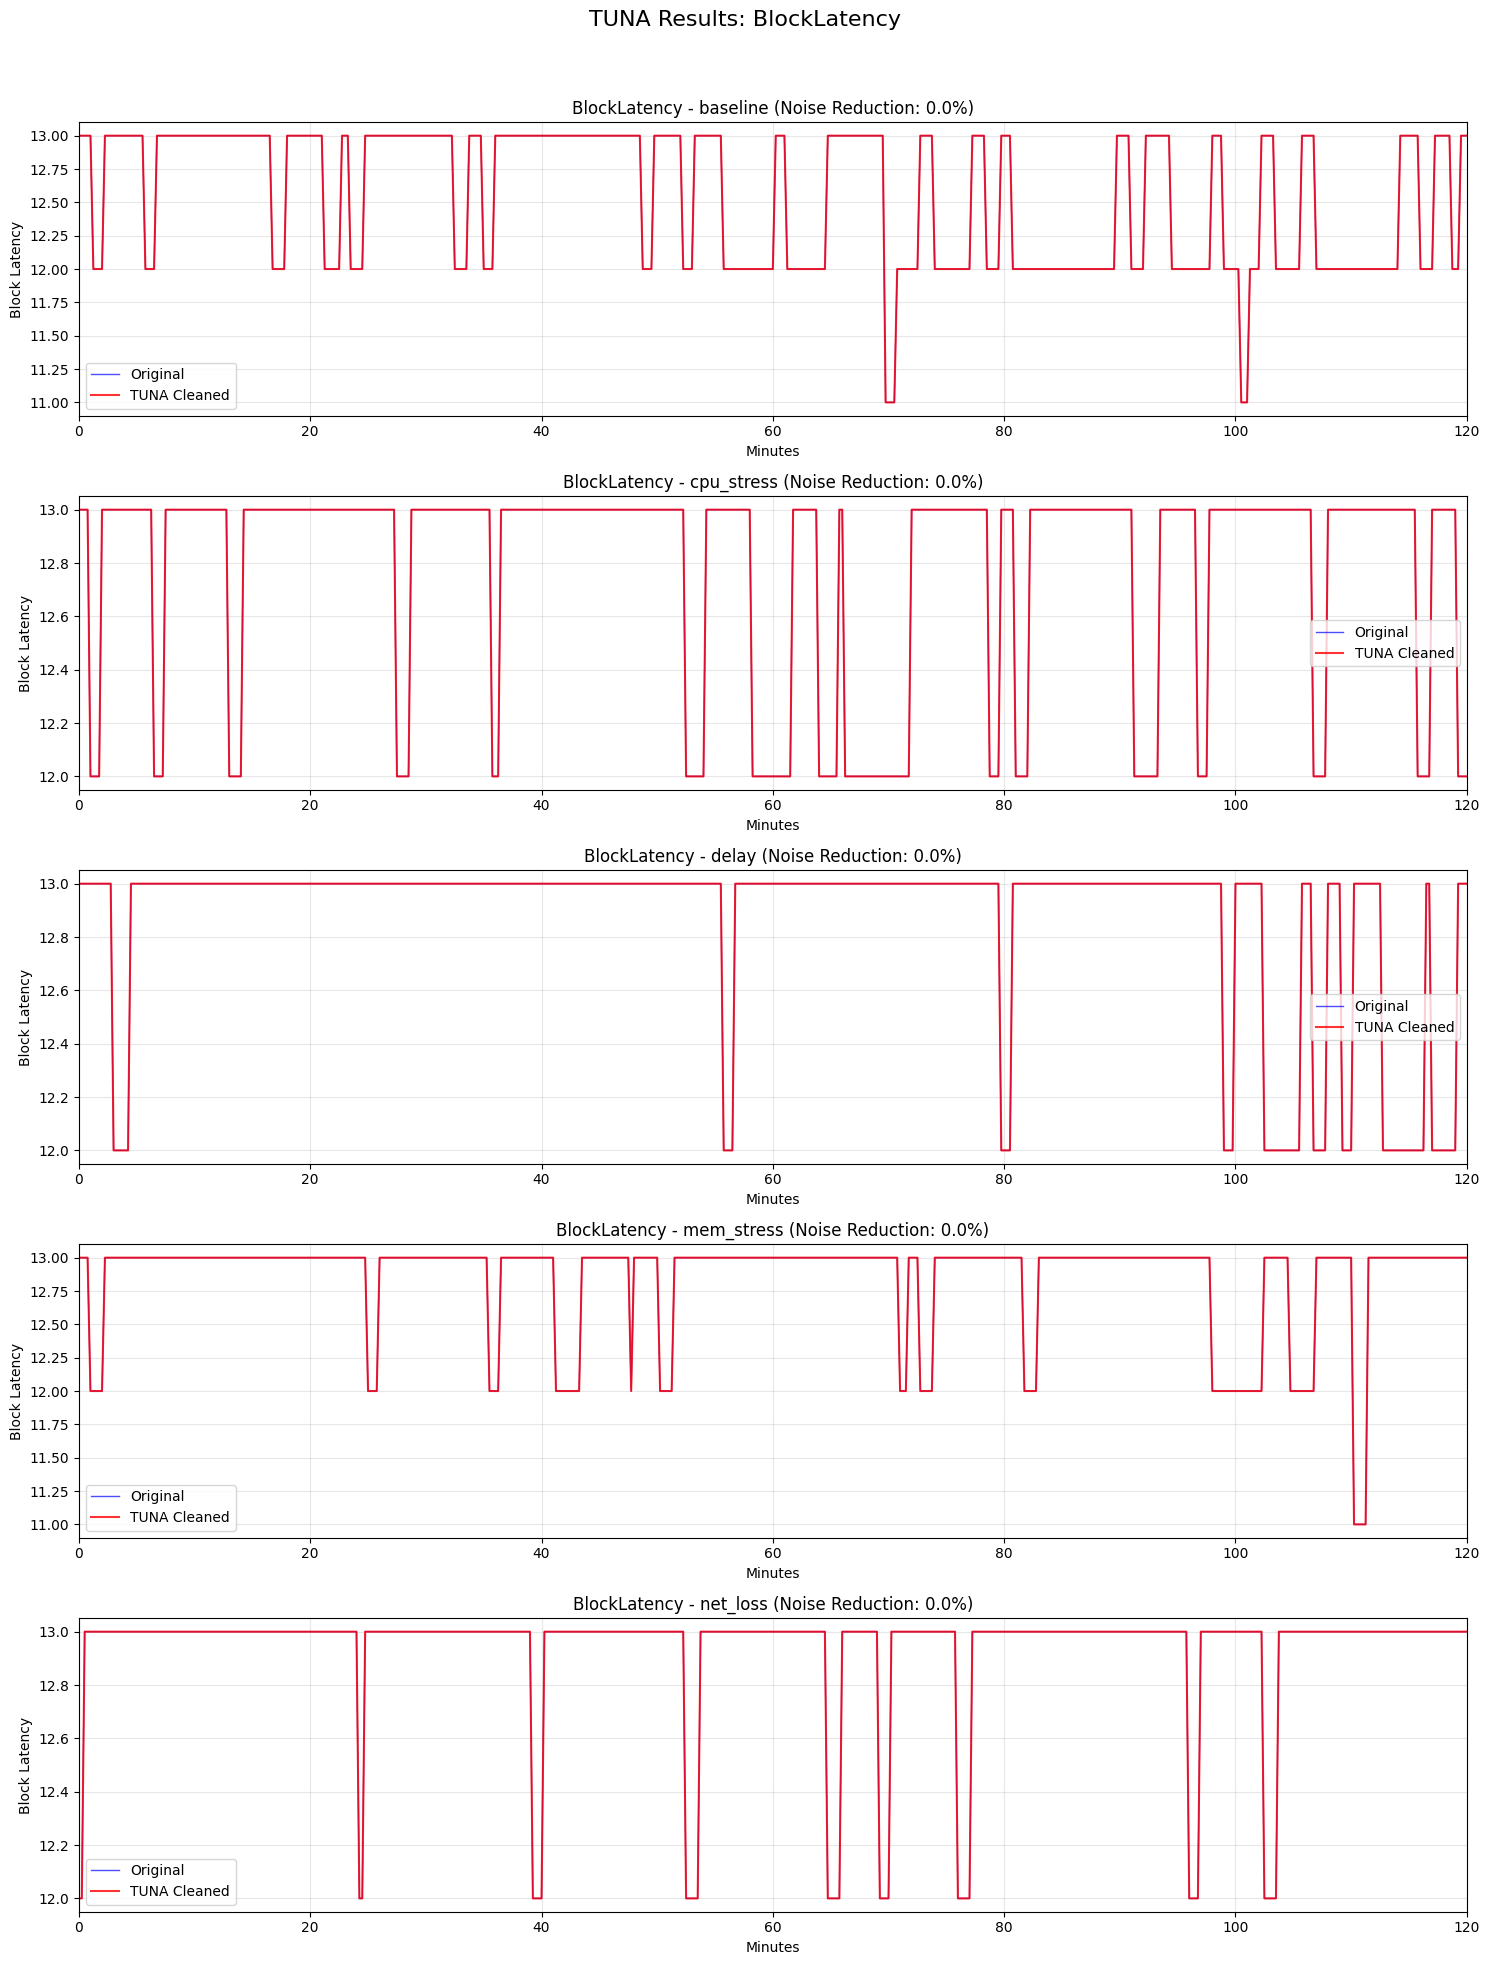

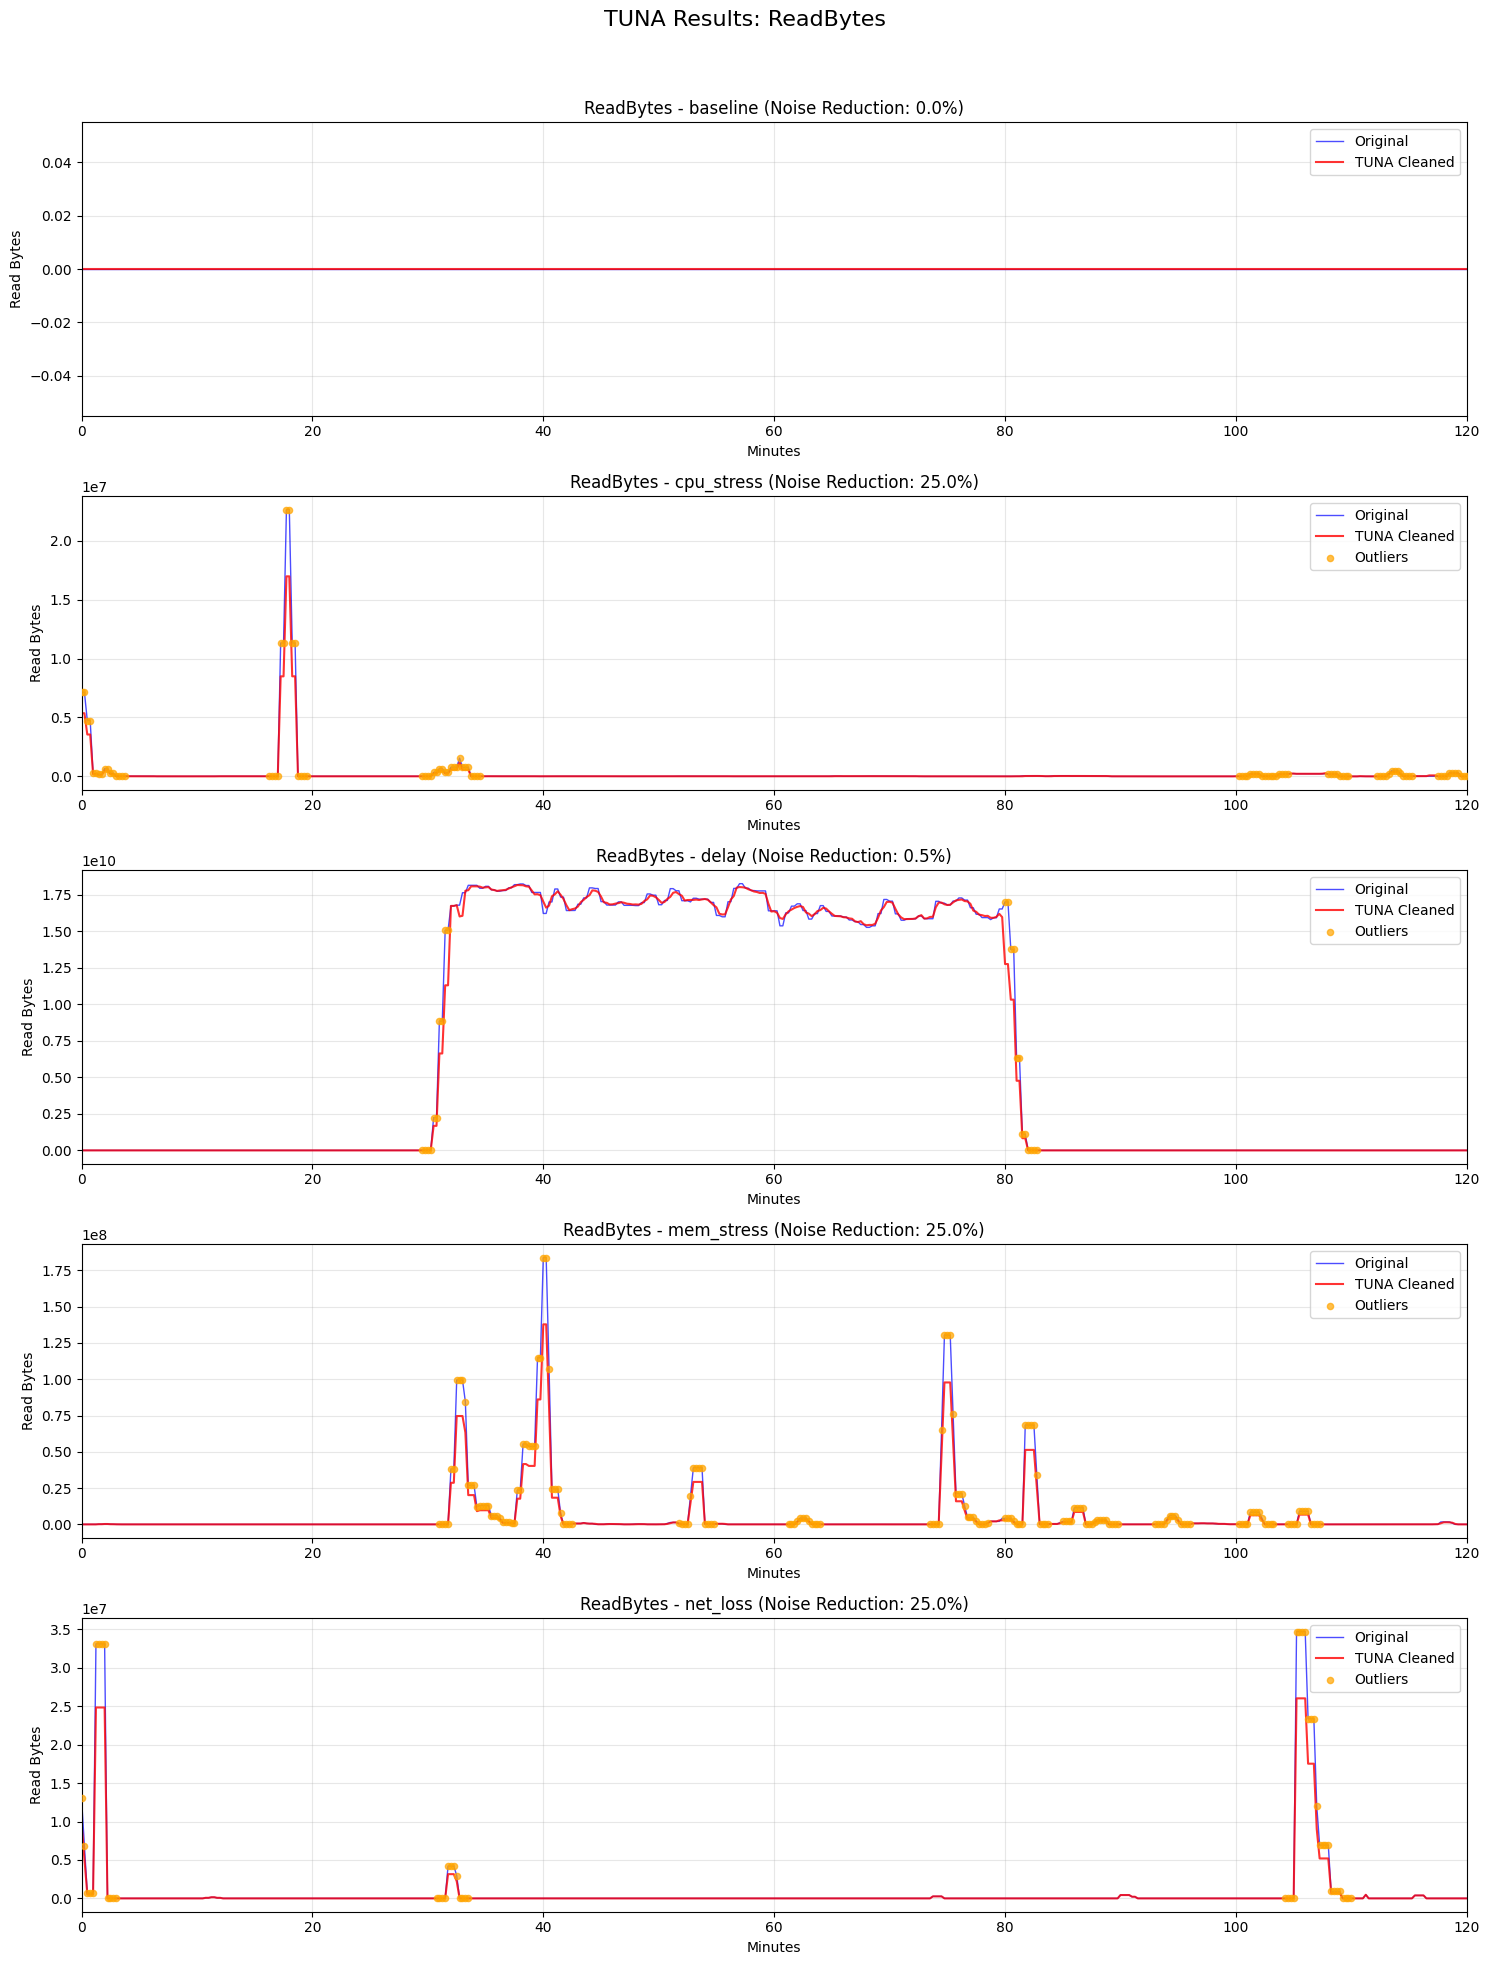

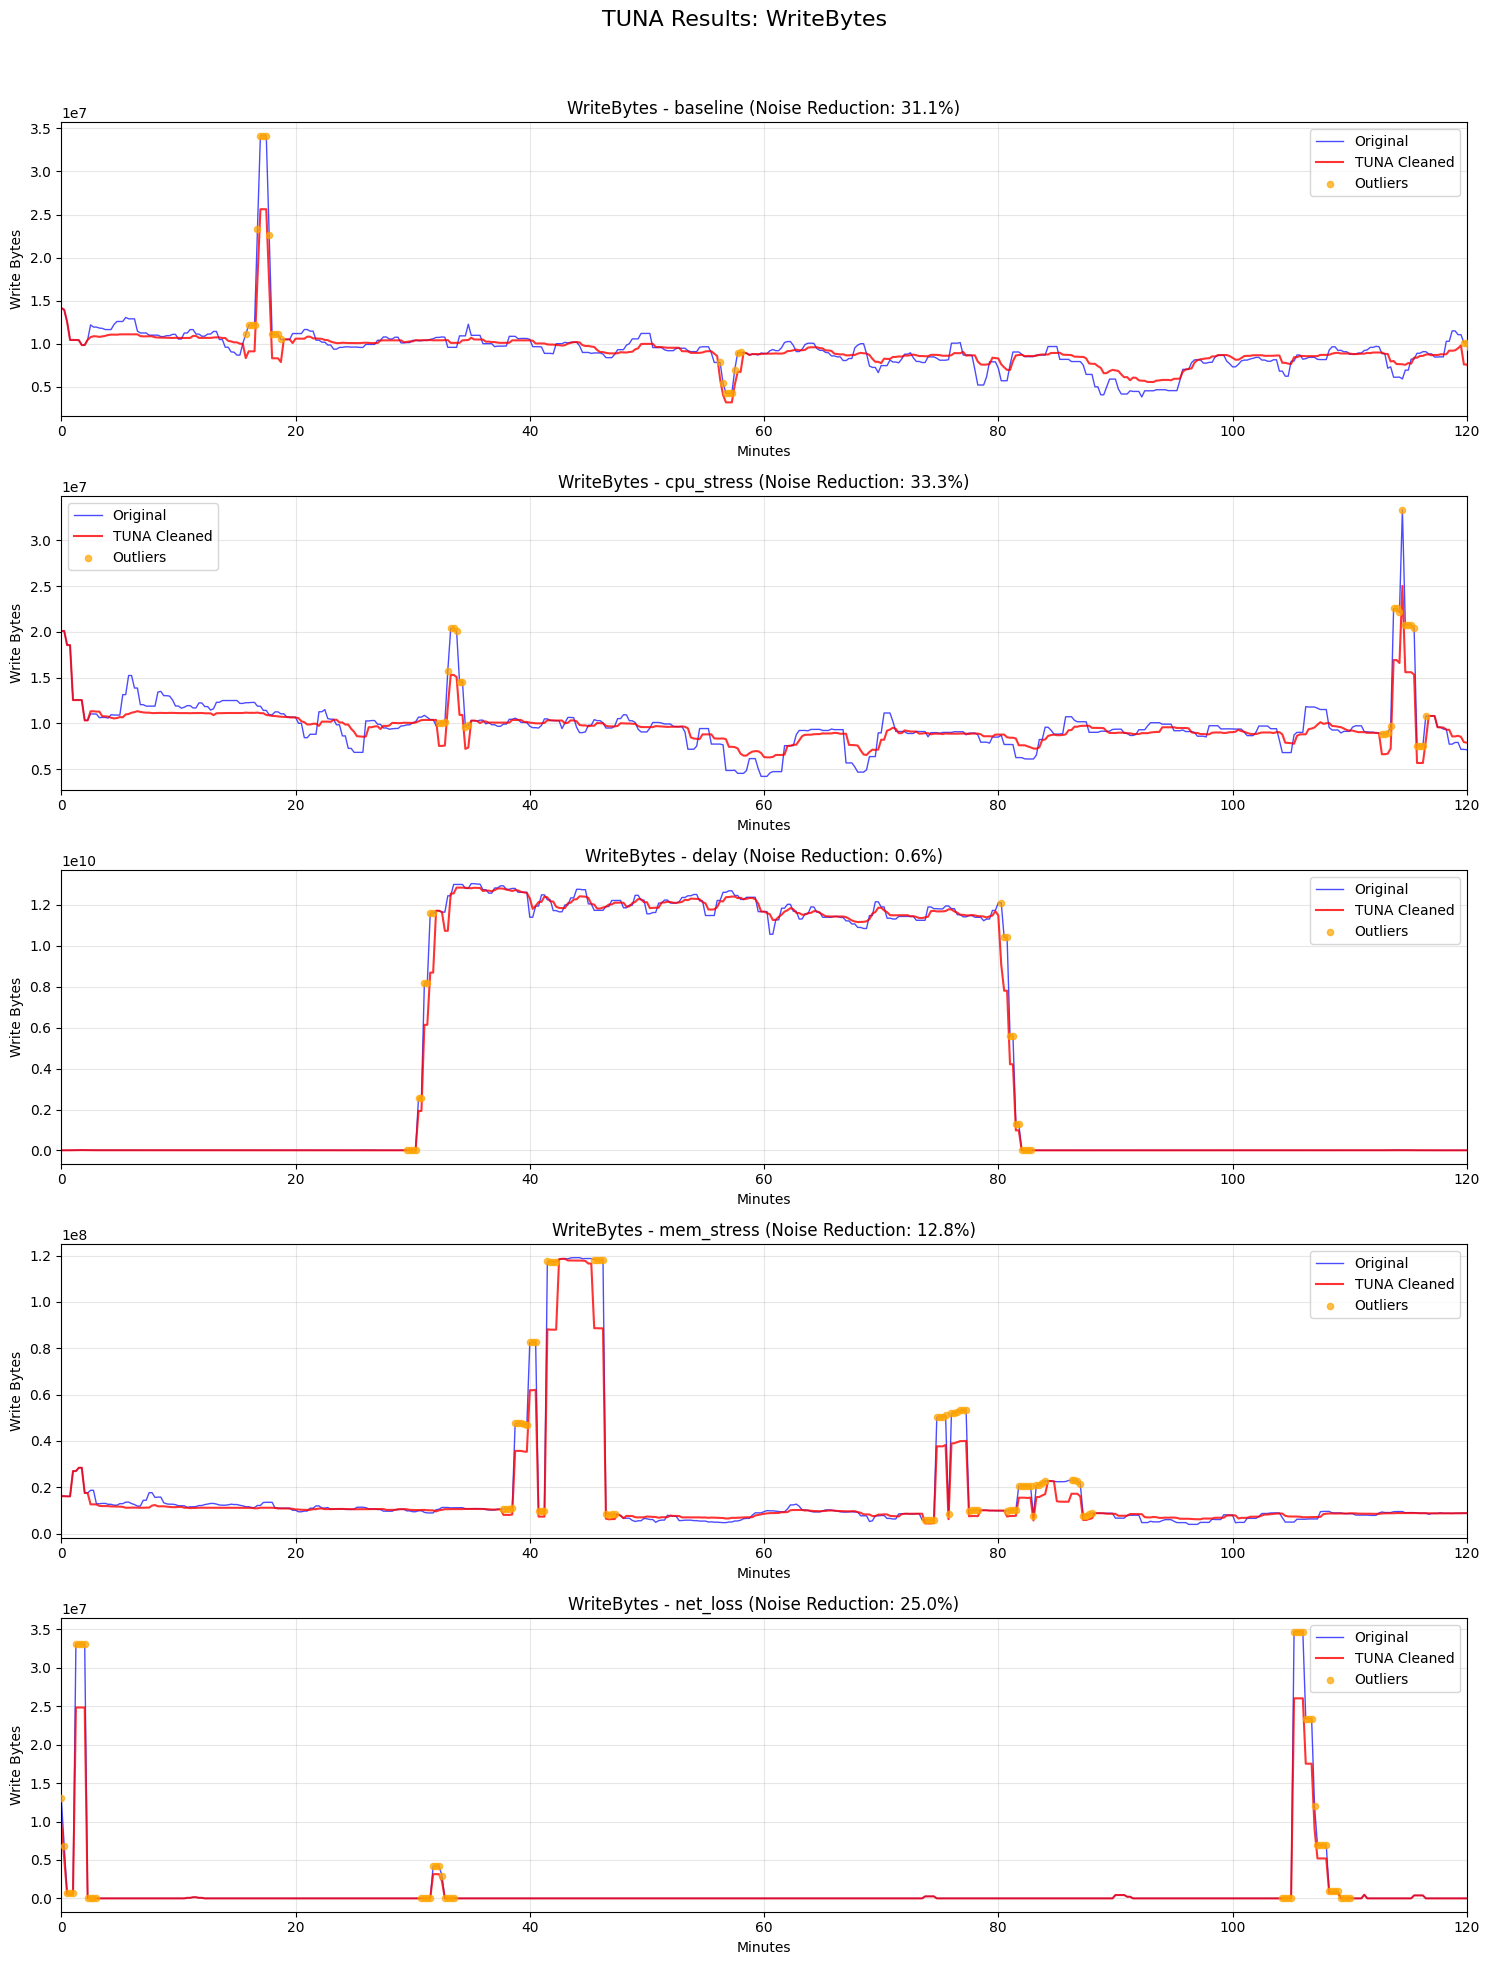


Disk I/O TUNA Results Summary:
Metric          Experiment   Outliers   Noise Red%   Correlation 
------------------------------------------------------------
BlockLatency    baseline     0                 0.0%       1.000
BlockLatency    cpu_stress   0                 0.0%       1.000
BlockLatency    delay        0                 0.0%       1.000
BlockLatency    mem_stress   0                 0.0%       1.000
BlockLatency    net_loss     0                 0.0%       1.000
ReadBytes       baseline     0                 0.0%         nan
ReadBytes       cpu_stress   101              25.0%       1.000
ReadBytes       delay        22                0.5%       0.998
ReadBytes       mem_stress   167              25.0%       1.000
ReadBytes       net_loss     49               25.0%       1.000
WriteBytes      baseline     26               31.1%       0.940
WriteBytes      cpu_stress   27               33.3%       0.913
WriteBytes      delay        21                0.6%       0.998
WriteByte

In [36]:
def extract_disk_values(df, metric_name):
    """Extract disk values - single column for DiskUtil, sum for ReadBytes/WriteBytes"""
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    if metric_name == 'DiskUtil':
        # For disk utilization, we typically have a single disk column
        if len(value_cols) == 1:
            return df[value_cols[0]].values
        else:
            # If multiple disks, take the primary one or sum (depending on use case)
            return df[value_cols[0]].values  # Take first disk as primary
    else:
        # For ReadBytes/WriteBytes, sum across all partitions/devices
        return df[value_cols].sum(axis=1).values

def detect_outliers_tuna(timeseries, window_size=5, threshold=0.65, min_absolute_range=None):
    """
    TUNA's relative range outlier detection with stability improvements
    Formula: (max - min) / mean > threshold
    Mark all values in unstable windows as outliers
    """
    outlier_mask = np.zeros(len(timeseries), dtype=bool)
    
    # Calculate adaptive minimum absolute range if not provided
    if min_absolute_range is None:
        # Use 5% of the overall time series standard deviation as minimum range
        min_absolute_range = 0.1 * np.std(timeseries)
    
    # Slide window across time series to detect unstable periods
    for i in range(len(timeseries) - window_size + 1):
        window = timeseries[i:i + window_size]
        window_mean = np.mean(window)
        window_range = np.max(window) - np.min(window)
        
        if window_mean > 0:
            # Apply TUNA relative range criterion
            relative_range = window_range / window_mean
            
            # Additional filter: require minimum absolute range to avoid hypersensitivity
            if relative_range > threshold and window_range > min_absolute_range:
                # Mark all values within unstable window as outliers
                for j in range(window_size):
                    actual_idx = i + j
                    outlier_mask[actual_idx] = True
    
    return outlier_mask

def create_features_for_ml(timeseries, outlier_mask, experiment_type, window_size=10):
    """Create features for ML training using only stable values in history"""
    features = []
    
    # Extract temporal and statistical features from sliding windows of STABLE values only
    for i in range(window_size, len(timeseries)):
        # Get the last window_size values, but only use stable ones
        stable_history = []
        for j in range(i - window_size, i):
            if j >= 0 and not outlier_mask[j]:  # Only include stable values
                stable_history.append(timeseries[j])
        
        # If we don't have enough stable history, skip this prediction
        if len(stable_history) < 3:
            continue
            
        # Pad with last stable value if needed
        while len(stable_history) < window_size:
            stable_history.append(stable_history[-1])
        
        # Statistical features from stable history only
        stable_window = np.array(stable_history)
        feature_vector = [
            np.mean(stable_window),                    # Rolling average of stable values
            np.std(stable_window),                     # Variability of stable values
            np.median(stable_window),                  # Robust central tendency
            np.max(stable_window) - np.min(stable_window),  # Range of stable values
            stable_history[-1],                        # Last stable value
            i / len(timeseries),                       # Temporal position
        ]
        
        # Experiment context encoding
        exp_features = [0, 0, 0, 0, 0]
        if experiment_type == "baseline":
            exp_features[0] = 1
        elif experiment_type == "cpu_stress":
            exp_features[1] = 1
        elif experiment_type == "delay":
            exp_features[2] = 1
        elif experiment_type == "mem_stress":
            exp_features[3] = 1
        elif experiment_type == "net_loss":
            exp_features[4] = 1
        
        feature_vector.extend(exp_features)
        features.append((i, feature_vector))  # Store index with features
    
    return features

def train_random_forest_for_metric(metric_name, all_experiments):
    """Train RandomForest on stable periods across all experiments using stable-only features"""
    print(f"Training {metric_name}...")
    
    X_stable_all = []
    y_stable_all = []
    
    # Aggregate stable training data from all experimental conditions
    for exp_name, df in all_experiments.items():
        values = extract_disk_values(df, metric_name)
        outlier_mask = detect_outliers_tuna(values)
        
        # Create features using only stable history
        indexed_features = create_features_for_ml(values, outlier_mask, exp_name)
        
        for idx, feature_vector in indexed_features:
            if not outlier_mask[idx]:  # Only train on stable targets
                X_stable_all.append(feature_vector)
                y_stable_all.append(values[idx])
    
    # Ensure sufficient training data
    if len(X_stable_all) < 10:
        return None, None
    
    X_stable_all = np.array(X_stable_all)
    y_stable_all = np.array(y_stable_all)
    
    # Standardize features for optimal model performance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_stable_all)

    # Hyperparameter grid for model optimization
    param_grid = {
        'n_estimators': [100],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    model = RandomForestRegressor(
        criterion='squared_error',
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    # Grid search with cross-validation for robust parameter selection
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_scaled, y_stable_all)
    model = grid_search.best_estimator_
    
    return model, scaler

def apply_penalty(timeseries, outlier_mask, penalty_factor=0.75):
    """Apply penalty to outliers by reducing their magnitude"""
    cleaned_series = timeseries.copy()
    
    # Apply penalty exactly once to each outlier
    outlier_indices = np.where(outlier_mask)[0]
    for i in outlier_indices:
        original_value = timeseries[i]
        if original_value != 0:  # Only apply penalty to non-zero values
            # Simple penalty: reduce magnitude by factor
            cleaned_series[i] = original_value * penalty_factor
        # Zero values remain zero (no penalty needed)
    
    return cleaned_series

def apply_tuna_to_single_series(values, exp_name, model, scaler, penalty_factor=0.75, blend_weight=1.0, metric_name=""):
    """Apply TUNA cleaning to a single time series with stable-history ML + penalty"""
    
    # Check data characteristics for smart ML application
    unique_values = len(np.unique(values))
    data_range = np.max(values) - np.min(values)
    zero_percentage = np.sum(values == 0) / len(values) * 100
    
    # Enhanced discrete data detection
    is_discrete_data = (
        unique_values <= 10 and data_range <= 50  # Low variety and range
        or zero_percentage > 60  # High percentage of zeros
        or (unique_values <= 20 and all(x == int(x) for x in np.unique(values) if not np.isnan(x)))  # All integers
    )
    
    outlier_mask = detect_outliers_tuna(values, window_size=5, threshold=0.65)
    
    stable_mask = ~outlier_mask
    outliers_count = np.sum(outlier_mask)
    
    # Phase 2: Apply penalty to outliers FIRST
    cleaned_series = apply_penalty(values, outlier_mask, penalty_factor)
    
    # Phase 3: Apply ML enhancement using stable history only
    if not is_discrete_data and model is not None and scaler is not None:
        try:
            # Create features using only stable history
            indexed_features = create_features_for_ml(values, outlier_mask, exp_name)
            
            for idx, feature_vector in indexed_features:
                if stable_mask[idx]:  # Only predict for stable periods
                    try:
                        features_scaled = scaler.transform([feature_vector])
                        ml_prediction = model.predict(features_scaled)[0]
                        cleaned_series[idx] = ml_prediction
                    except:
                        # If prediction fails, keep the penalty-adjusted value
                        pass
            
            # Ensure non-negative values for count data
            cleaned_series = np.maximum(0, cleaned_series)
            
            print(f"  ✓ Applied stable-history ML + penalty (factor: {penalty_factor}) for {metric_name} - {exp_name}")
            
        except Exception as e:
            print(f"  ⚠ ML enhancement failed for {metric_name} - {exp_name}: {str(e)}")
    else:
        if is_discrete_data:
            print(f"  ℹ Applied penalty-only (factor: {penalty_factor}) for {metric_name} - {exp_name} (discrete data)")
        else:
            print(f"  ℹ Applied penalty-only (factor: {penalty_factor}) for {metric_name} - {exp_name} (no model)")
    
    # Calculate cleaning statistics
    original_std = np.std(values)
    cleaned_std = np.std(cleaned_series)
    noise_reduction = (original_std - cleaned_std) / original_std * 100 if original_std > 0 else 0
    correlation = np.corrcoef(values, cleaned_series)[0, 1] if len(values) > 1 else 1.0
    
    cleaning_stats = {
        'outliers': outliers_count,
        'outlier_percentage': (outliers_count / len(values)) * 100,
        'noise_reduction': noise_reduction,
        'correlation': correlation,
        'mean_before': np.mean(values),
        'mean_after': np.mean(cleaned_series),
        'std_before': original_std,
        'std_after': cleaned_std,
        'zero_percentage': zero_percentage,
        'unique_values': unique_values,
        'data_type': 'discrete' if is_discrete_data else 'continuous',
        'penalty_factor': penalty_factor
    }
    
    return cleaned_series, outlier_mask, cleaning_stats

def run_tuna_for_all_metrics():
    """Run TUNA for all disk metrics"""
    print("Running TUNA analysis on disk I/O datasets...")
    
    tuna_results = {}
    
    # Process each disk metric independently
    for metric_name, experiments in all_datasets.items():
        print(f"Processing {metric_name}")
        
        # Train metric-specific model on cross-experiment stable data
        model, scaler = train_random_forest_for_metric(metric_name, experiments)
        
        # Apply cleaning to each experimental condition
        metric_results = {}
        for exp_name, df in experiments.items():
            values = extract_disk_values(df, metric_name)
            cleaned_series, outlier_mask, stats = apply_tuna_to_single_series(
                values, exp_name, model, scaler, metric_name=metric_name
            )
            
            metric_results[exp_name] = {
                'original': values,
                'cleaned': cleaned_series,
                'outliers': outlier_mask,
                'stats': stats
            }
        
        tuna_results[metric_name] = metric_results
    
    return tuna_results

def plot_tuna_results(tuna_results):
    """Plot TUNA results with original vs cleaned comparison using Minutes (0-120) x-axis"""
    
    for metric_name, metric_results in tuna_results.items():
        n_experiments = len(metric_results)
        fig, axes = plt.subplots(n_experiments, 1, figsize=(15, 4*n_experiments))
        
        if n_experiments == 1:
            axes = [axes]
        
        # Visualize cleaning results for each experiment
        for i, (exp_name, results) in enumerate(metric_results.items()):
            original = results['original']
            cleaned = results['cleaned']
            outliers = results['outliers']
            stats = results['stats']
            
            # Get the corresponding dataframe to extract Minutes column
            df = all_datasets[metric_name][exp_name]
            minutes = df['Minutes'].values
            
            # Plot time series with cleaning overlay using Minutes as x-axis
            axes[i].plot(minutes, original, 'b-', alpha=0.7, label='Original', linewidth=1)
            axes[i].plot(minutes, cleaned, 'r-', alpha=0.8, label='TUNA Cleaned', linewidth=1.5)
            
            # Highlight detected outliers
            outlier_points = np.where(outliers)[0]
            if len(outlier_points) > 0:
                axes[i].scatter(minutes[outlier_points], original[outlier_points], 
                               c='orange', s=20, alpha=0.7, label='Outliers', zorder=5)
            
            # Set appropriate y-axis label based on metric
            if 'block' in metric_name.lower() or 'latency' in metric_name.lower():
                y_label = 'Block Latency'
            elif 'read' in metric_name.lower():
                y_label = 'Read Bytes'
            elif 'write' in metric_name.lower():
                y_label = 'Write Bytes'
            else:
                y_label = 'Values'
            
            axes[i].set_title(f'{metric_name} - {exp_name} (Noise Reduction: {stats["noise_reduction"]:.1f}%)')
            axes[i].set_xlabel('Minutes')
            axes[i].set_ylabel(y_label)
            axes[i].set_xlim(0, 120)  # Set x-axis to match your experiment duration
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.suptitle(f'TUNA Results: {metric_name}', fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def print_tuna_summary(tuna_results):
    """Print summary table of cleaning effectiveness"""
    print("\nDisk I/O TUNA Results Summary:")
    print("="*60)
    print(f"{'Metric':<15} {'Experiment':<12} {'Outliers':<10} {'Noise Red%':<12} {'Correlation':<12}")
    print("-"*60)
    
    # Tabulate results across all metrics and experiments
    for metric_name, metric_results in tuna_results.items():
        for exp_name, results in metric_results.items():
            stats = results['stats']
            print(f"{metric_name:<15} {exp_name:<12} {stats['outliers']:<10} "
                  f"{stats['noise_reduction']:>10.1f}% {stats['correlation']:>11.3f}")

# Execute complete TUNA analysis pipeline
tuna_results = run_tuna_for_all_metrics()
plot_tuna_results(tuna_results)
print_tuna_summary(tuna_results)